# Mapa

Prvo definišemo mapu gradova


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

united_states_map = mpimg.imread("united_states_map.png")
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    plt.imshow(united_states_map)
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = žute zvijezde kao početne tačke
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])


def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]

    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = početni grad
    (x0, y0) = starting_city
    plt.imshow(united_states_map)
    # plt.plot(x0, y0, 'y*', markersize=15)  # y* = žute zvijezde kao početne tačke
    plt.plot(x + x[:1], y + y[:1])  # uključimo početnu tačku na kraj puta
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])


def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])

    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)
    plt.title(" + ".join(reversed(terms)))

In [3]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]
    ))

30


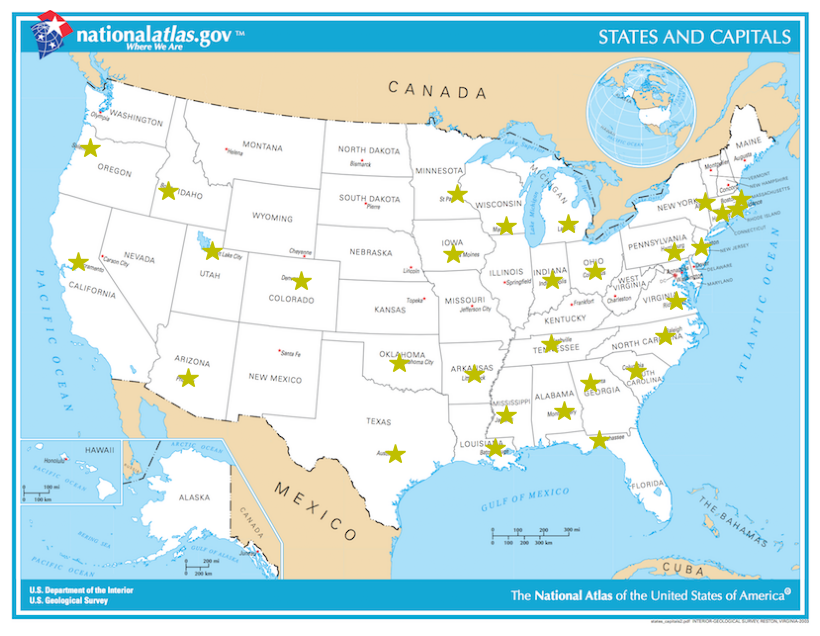

In [4]:
cities = {
    "Oklahoma City": (392.8, 356.4),
    "Montgomery": (559.6, 404.8),
    "Saint Paul": (451.6, 186.0),
    "Trenton": (698.8, 239.6),
    "Salt Lake City": (204.0, 243.2),
    "Columbus": (590.8, 263.2),
    "Austin": (389.2, 448.4),
    "Phoenix": (179.6, 371.2),
    "Hartford": (719.6, 205.2),
    "Baton Rouge": (489.6, 442.0),
    "Salem": (80.0, 139.2),
    "Little Rock": (469.2, 367.2),
    "Richmond": (673.2, 293.6),
    "Jackson": (501.6, 409.6),
    "Des Moines": (447.6, 246.0),
    "Lansing": (563.6, 216.4),
    "Denver": (293.6, 274.0),
    "Boise": (159.6, 182.8),
    "Raleigh": (662.0, 328.8),
    "Atlanta": (585.6, 376.8),
    "Madison": (500.8, 217.6),
    "Indianapolis": (548.0, 272.8),
    "Nashville": (546.4, 336.8),
    "Columbia": (632.4, 364.8),
    "Providence": (735.2, 201.2),
    "Boston": (738.4, 190.8),
    "Tallahassee": (594.8, 434.8),
    "Sacramento": (68.4, 254.0),
    "Albany": (702.0, 193.6),
    "Harrisburg": (670.8, 244.0)
}
cities = list(sorted(cities.items()))
print(len(cities))
show_cities(cities)

7074

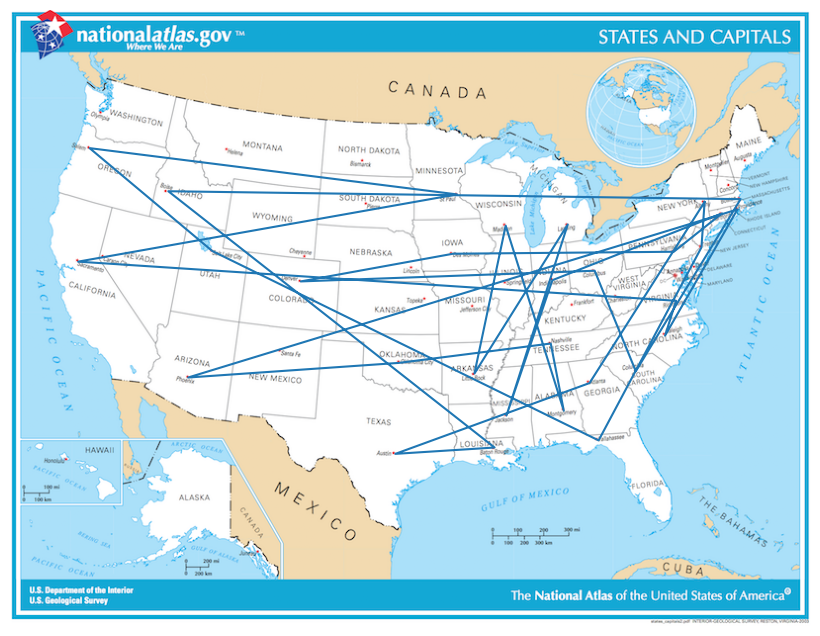

In [5]:
show_path(cities)
path_distance(cities)

# Upoznajte koloniju mrava

- Iz razloga performansi, mravi su predstavljeni skupom NumPy nizova širine 2048, što omogućava brze vektorske operacije  
- Mnogi parametri su prilagodljivi i utiču na internu logiku kolonije, ali su postavljeni na razumske/optimalne početne vrijednosti  
- Glavna logika algoritma:

    - šaljemo mrave na slučajnu šetnju, pri čemu svaki individualno rješava Problem trgovačkog putnika  
        - `ant_count` određuje broj mrava u NumPy nizu  
        - `ant_speed` određuje koliko koraka svaki mrav napravi po epohi  

    - svaki mrav prati:
        - `path` — listu gradova koje je prethodno posjetio  
        - skup `remaining` gradova koje još treba posjetiti  
        - `distance` do naredne destinacije  
        - `path_cost` — ukupan broj koraka pređenih do sada  
        - `round_trips` — broj potpunih krugova nazad do kolonije  

    - tokom kretanja, vektorski se smanjuje `distance`  

    - kad mrav stigne na čvor:
        - slučajno bira novu destinaciju iz preostalog skupa  
        - izbor je ponderiran količinom feromona koje su ostavili ostali mravi  
        - `pheromone_power` utiče na osjetljivost mrava na male razlike u feromonima  
        - `distance_power` utiče na preferenciju posjete bližih čvorova  
        - `reward_power` utiče na to kako se `best_path/current_path` koristi pri ostavljanju novih feromona  
            - eksperimentima je `** -3` pokazao optimalne rezultate  
            - to podstiče mrave da istraže duže puteve oko jakih tragova feromona  
        - `decay_power` utiče na brzinu isparavanja starih feromonskih tragova  
        - nakon što posjete sve čvorove, vraćaju se u koloniju  

    - kad se mrav vrati:
        - ažurira `self.pheromones` mapu prema pređenom putu, signalizirajući popularnost te rute  
        - nagrada u feromonima raste s `self.round_trips`, postepeno slabeći stare tragove  
        - ažurira brojač `self.ants_used`  
        - povećava svoj `self.round_trips`  
        - resetuje se i ponovo pokreće Problem trgovačkog putnika  

    - ako mrav nađe rekordno najbolju putanju:
        - obavještava kraljicu koja evidentira najbolju rutu  
        - kraljica udvostručuje feromone na toj putanji, povećavajući vjerovatnoću njenog istraživanja  
        - `best_path_smell` određuje jačinu tog pojačanja  

    - Prekid rada: dostupne opcije:
        - `self.stop_factor` — pojačava napore nakon pronalaska novog najboljeg puta prije prekida  
            - faktor 2 produžava trajanje rada na dvostruko od vremena pronalaska zadnje najbolje putanje  
            - faktor 4 pouzdanije sprječava prerani prekid, ali produžava izvršavanje  
        - `self.time` — maks. trajanje rada u sekundama prije završetka  
        - `self.min_time` — min. trajanje rada prije prirodnog prekida  
        - `self.timeout` — maksimalni period rada, uz mogući raniji prekid  
        - `self.round_trips` — minimalan broj `round_trips` potreban za prekid (zadano 4)  


In [6]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],

                 time=0,                  # izvršavanje tokom određenog vremena
                 min_time=0,              # minimalno vrijeme izvršavanja
                 timeout=0,               # maksimalno dozvoljeno vrijeme izvršavanja u sekundama
                 stop_factor=2,           # koliko puta povećati napor nakon pronalaska nove najbolje putanje
                 min_round_trips=10,      # minimalan broj kompletnih obilazaka prije zaustavljanja
                 max_round_trips=0,       # maksimalan broj kompletnih obilazaka prije zaustavljanja
                 min_ants=0,              # minimalan broj mrava koji se koriste
                 max_ants=0,              # maksimalan broj mrava koji se koriste

                 ant_count=64,            # donja granica optimalnog raspona za performanse s NumPy-jem
                 ant_speed=1,             # koliko koraka mravi naprave po epohi

                 distance_power=1,        # stepen u kojem udaljenost utiče na feromone
                 pheromone_power=1.25,    # stepen u kojem se uočavaju razlike u feromonima
                 decay_power=0,           # brzina isparavanja feromona
                 reward_power=0,          # relativna nagrada u feromonima na osnovu omjera najbolje dužine putanje i dužine trenutne putanje
                 best_path_smell=2,       # faktor pojačanja feromona kada kraljica pronađe novu najbolju putanju
                 start_smell=0,           # početna količina feromona [0 znači podrazumijevana vrijednost `10**self.distance_power`]

                 verbose=False,           # ispis dodatnih informacija tokom izvršavanja (detaljan prikaz)

    ):
        assert callable(cost_fn)
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)

        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)

        self.distance_power  = float(distance_power)
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)

        self.verbose         = int(verbose)
        self._initalized     = False

        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Keširanje udaljenosti između čvorova
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Keširanje udaljenosti između čvorova - podjela na "tight loop" je skupa
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Spašava feromonski trag koji se polako nakuplja
        self.pheromones = {
            source: {
                # Podržava mrave da istražuju sve smjerove i daleke čvorove
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }

        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))

        ### Heuristički eksporti
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vektorizirani hod mrava
            # Optimizacija, testiranje sa `> self.ant_speed` umjesto sa `> 0`
            #       izbjegava računanje ants_arriving u glavnom dijelu petlje
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # preskače terminirajuće provjere dok se ne pojavi idući mrav
            ### Vektoriziranje dolazećih mrava
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### mrav je došao na next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### mrav se vratio u koloniju
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### pronađen je novi najbolji put - informiši kraljicu
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### ostavi feromonski trag
                    # radeći ovo samo nakon što se mravi vrate u koloniju popravlja inicijalnu eksploraciju
                    #  * self.round_trips ima efekat starog feromonskog traga
                    # ** self.reward_power = -3 ima efekat podrške mravima da istražuju duže rute
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Kraljica naređuje da se broj mrava udupla nakon što se pronađe novi najbolji put
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### resetuj mrava
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Da li ćemo terminirati?

            # Čekat ćemo najmanje jedno rješenje (2+ rješenja nisu grantovana)
            if not len(best_epochs): continue

            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break

            # Prva epoha ima samo početni trag -
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            if self.min_ants and self.ants_used <  self.min_ants: continue
            if self.max_ants and self.ants_used >= self.max_ants: break

            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break

            if True: continue

        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node


def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }

    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

# Rješavanje Problema trgovačkog putnika (TSP)

Prva grupa mrava brzo pronađe razumnu putanju, a zatim se kolonija brzo konvergira na gotovo optimalnu putanju  
- U svakom trenutku putuje 1024 mrava  
- Mravi prate i ostavljaju feromonske tragove, a za izbor sljedećeg grada koriste i metriku `1/udaljenost`  
- Prvobitno su koristili heuristiku `1/udaljenost^2`, ali nakon podešavanja hiperparametara otkriveno je da `1/udaljenost` daje ekvivalentne rezultate (i sada je zadano)  
- Mravi će pojačavati napore sve dok ne prestanu pronalaziti bolju putanju  


{'path_cost': 3836, 'ants_used': 1, 'epoch': 3792, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 3664, 'ants_used': 131, 'epoch': 12797, 'round_trips': np.int32(3), 'clock': 0}
{'path_cost': 3493, 'ants_used': 134, 'epoch': 12910, 'round_trips': np.int32(3), 'clock': 0}
{'path_cost': 3382, 'ants_used': 170, 'epoch': 14219, 'round_trips': np.int32(3), 'clock': 0}
{'path_cost': 3349, 'ants_used': 176, 'epoch': 14453, 'round_trips': np.int32(3), 'clock': 0}
{'path_cost': 3302, 'ants_used': 195, 'epoch': 16057, 'round_trips': np.int32(4), 'clock': 0}
{'path_cost': 3142, 'ants_used': 196, 'epoch': 16150, 'round_trips': np.int32(4), 'clock': 0}
{'path_cost': 3072, 'ants_used': 201, 'epoch': 16470, 'round_trips': np.int32(4), 'clock': 0}
{'path_cost': 2987, 'ants_used': 234, 'epoch': 17588, 'round_trips': np.int32(4), 'clock': 0}
{'path_cost': 2719, 'ants_used': 235, 'epoch': 17667, 'round_trips': np.int32(4), 'clock': 0}
{'path_cost': 2570, 'ants_used': 269, 'epoch': 19606, 'round_tr

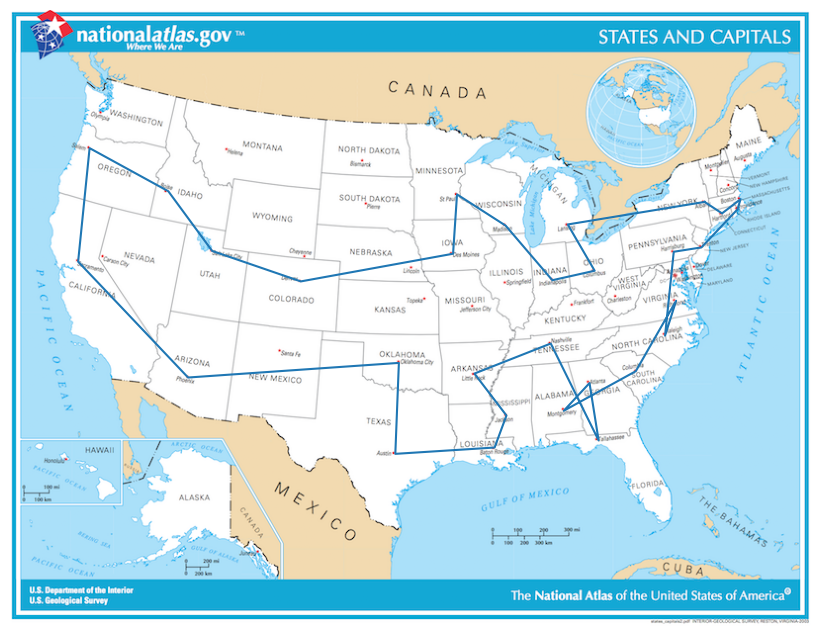

In [7]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)

# Rješavanje s divljim mravima

Naravno, ovi mravi varaju. Vide udaljenosti i naučeni su da znatno preferiraju posjetu bližim čvorovima koristeći kvadrirani faktor.  
U divljini bi mravi bili slijepi za sve osim feromonskog traga, pa da vidimo kako ovo djeluje na algoritam.

- Mravi se polako, ali sistematično konvergiraju ka boljim rješenjima  
- Krajnja putanja je 30% duža nego kod mrava sa heuristikom `udaljenost^2` (2843 naspram 2203)  
- Prvi mrav koji se vratio prešao je putanju skoro duplo dužu nego mrav sa heuristikom `udaljenost^2` (5906 naspram 2987)  
- Algoritam je bio znatno zahtjevniji, sa 6× većim vremenom izvršavanja (94 s naspram 16 s)  
- Dobiveni graf sadrži više petlji i oštrih uglova, jer oni prikazuju glavne puteve otkrivene tokom početne eksploracije  
- Iako putanja nije savršena, i dalje je dovoljno dobra da spriječi da mravi u divljini izgladne  
- Povremeno dolazi do prerane završnice, pa je potreban dodatni uslov za prekid, `min_ants`, kako bi se to spriječilo  


{'path_cost': 6722, 'ants_used': 1, 'epoch': 6474, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 5815, 'ants_used': 65, 'epoch': 13099, 'round_trips': np.int32(2), 'clock': 0}
{'path_cost': 5804, 'ants_used': 70, 'epoch': 13736, 'round_trips': np.int32(2), 'clock': 0}
{'path_cost': 5561, 'ants_used': 501, 'epoch': 61120, 'round_trips': np.int32(9), 'clock': 0}
{'path_cost': 5518, 'ants_used': 570, 'epoch': 68988, 'round_trips': np.int32(10), 'clock': 0}
N=30  |  7074 -> 5532 |    1s | ants:   724 | trips:   12 | distance_power=0 stop_factor=1.25


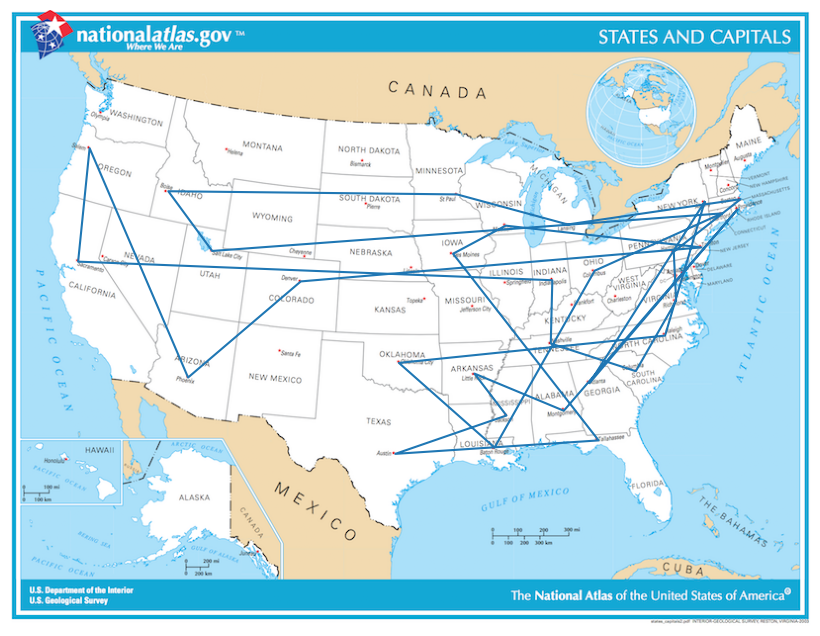

In [8]:
results = AntColonyRunner(cities, distance_power=0, stop_factor=1.25, verbose=True, plot=True)

Došli smo do prerane završnice. Pokušajmo to popraviti:

{'path_cost': 5828, 'ants_used': 1, 'epoch': 5628, 'round_trips': np.int32(1), 'clock': 0}
{'path_cost': 5364, 'ants_used': 246, 'epoch': 30200, 'round_trips': np.int32(4), 'clock': 0}
{'path_cost': 5134, 'ants_used': 914, 'epoch': 103245, 'round_trips': np.int32(15), 'clock': 1}
{'path_cost': 4935, 'ants_used': 1071, 'epoch': 119372, 'round_trips': np.int32(17), 'clock': 1}
{'path_cost': 4719, 'ants_used': 1356, 'epoch': 148546, 'round_trips': np.int32(22), 'clock': 1}
{'path_cost': 4291, 'ants_used': 1469, 'epoch': 158709, 'round_trips': np.int32(24), 'clock': 1}
{'path_cost': 4181, 'ants_used': 1816, 'epoch': 189676, 'round_trips': np.int32(29), 'clock': 2}
{'path_cost': 4057, 'ants_used': 2429, 'epoch': 241122, 'round_trips': np.int32(39), 'clock': 2}
{'path_cost': 3989, 'ants_used': 2871, 'epoch': 276120, 'round_trips': np.int32(46), 'clock': 3}
{'path_cost': 3663, 'ants_used': 2909, 'epoch': 279322, 'round_trips': np.int32(47), 'clock': 3}
{'path_cost': 3560, 'ants_used': 3344, '

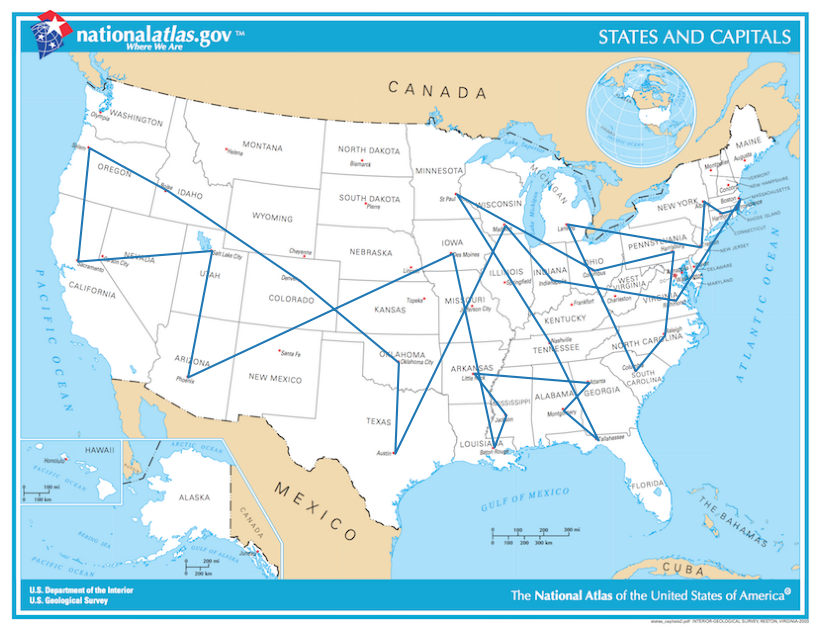

In [9]:
results = AntColonyRunner(cities, distance_power=0, min_time=30, verbose=True, plot=True)

# Statistička slučajna varijacija

Iako Ant Colony Optimization algoritam nije "kompletan" u smislu da ne garantuje pronalazak optimalne putanje, on brzo konvergira ka gotovo optimalnoj putanji koja može biti prihvatljiva za mnoge primjene.

Sadrži stohastički model, ali statisticka analiza pokazuje:

- Za konvergirane rezultate:
  - standardna devijacija je 20.8, sto je približno 1% srednje dužine putanje (2211.1)  
  - razlika izmedu maksimalne i minimalne dužine putanje je 50 (2.5%)  
  - prosjecno vrijeme do konvergencije je 47.2 s  

- Rad na fiksnom vremenskom ogranicenju od 10 s:
  - standardna devijacija se blago smanjuje na 17.3  
  - prosjecna duzina putanje je samo 20 (1%) veca nego za konvergirane rezultate  

Ovo pokazuje da je algoritam prilično dosljedan i da i uz raniji prekid može davati prihvatljive rezultate. Zakon opadajucih prinosa vazi za produženo izvođenje algoritma.


In [10]:
results_converged = [ AntColonyRunner(cities) for i in range(10) ]

N=30  |  7074 -> 2227 |    1s | ants:  1656 | trips:   27 | 
N=30  |  7074 -> 2278 |    1s | ants:  1350 | trips:   22 | 
N=30  |  7074 -> 2353 |    4s | ants:  3689 | trips:   59 | 
N=30  |  7074 -> 2308 |    3s | ants:  2386 | trips:   39 | 
N=30  |  7074 -> 2412 |    5s | ants:  5567 | trips:   88 | 
N=30  |  7074 -> 2212 |    1s | ants:  1672 | trips:   28 | 
N=30  |  7074 -> 2354 |    2s | ants:  2507 | trips:   41 | 
N=30  |  7074 -> 2612 |    1s | ants:  1472 | trips:   24 | 
N=30  |  7074 -> 2301 |    5s | ants:  3035 | trips:   48 | 
N=30  |  7074 -> 2268 |    3s | ants:  3709 | trips:   60 | 


In [11]:
results_timed = [ AntColonyRunner(cities, time=10) for i in range(10) ]

N=30  |  7074 -> 2345 |   10s | ants: 11665 | trips:  184 | time=10
N=30  |  7074 -> 2274 |   10s | ants: 13788 | trips:  217 | time=10
N=30  |  7074 -> 2298 |   10s | ants: 11472 | trips:  181 | time=10
N=30  |  7074 -> 2326 |   10s | ants:  9683 | trips:  153 | time=10
N=30  |  7074 -> 2340 |   10s | ants: 12865 | trips:  202 | time=10
N=30  |  7074 -> 2253 |   10s | ants: 11529 | trips:  182 | time=10
N=30  |  7074 -> 2298 |   10s | ants: 11044 | trips:  175 | time=10
N=30  |  7074 -> 2352 |   10s | ants: 10893 | trips:  171 | time=10
N=30  |  7074 -> 2200 |   10s | ants: 13516 | trips:  213 | time=10
N=30  |  7074 -> 2216 |   10s | ants: 11457 | trips:  180 | time=10


In [12]:
import pandas as pd
results_converged_stats = pd.Series([ path_distance(path) for path in results_converged ]).describe()
results_timed_stats     = pd.Series([ path_distance(path) for path in results_timed     ]).describe()
pd.DataFrame({
    "results_converged": results_converged_stats,
    "results_timed":     results_timed_stats,
    "difference":        results_converged_stats - results_timed_stats,
}).T.round(1)

,count,mean,std,min,25%,50%,75%,max
results_converged,10.0,2332.5,115.3,2212.0,2270.5,2304.5,2353.8,2612.0
results_timed,10.0,2290.2,53.7,2200.0,2258.2,2298.0,2336.5,2352.0
difference,0.0,42.3,61.6,12.0,12.2,6.5,17.2,260.0


# Optimizacija hiperparametara

Postoje različiti hiperparametri koje možete prilagoditi:
```python
- ant_count=2048,        # ovo je blizu optimalnog broja mrava za performanse  
- ant_speed=1,           # koliko koraka mravi prijeđu po epohi  
- start_smell=0,         # početna količina feromona [0 podrazumijeva `10**self.distance_power`]  
- best_path_smell=2,     # faktor kojim kraljica množi feromone nakon pronalaska nove najbolje putanje  
- reward_power=-3,       # kontradiktorno, -3 nagrađuje duže puteve i podstiče veću eksploraciju  
- distance_power=2,      # stepen u kojem udaljenost utiče na feromone  
- pheromone_power=1,     # stepen u kojem se razlike u feromonima uočavaju  
- decay_power=1,         # brzina isparavanja feromonskih tragova  


# ant_count

Ovo zaista pokazuje uticaj performansi pri korištenju vektorizovanih NumPy nizova u odnosu na Python petlje  
- posmatrajte broj generisanih mrava  
- operacije na NumPy nizovima imaju linearni režijski trošak  
- upotreba vrlo malih nizova (4 ili manje) može biti znatno sporija nego upotreba Python primitiva  
- raspon od 256 do 4096 je idealan za optimalnu veličinu NumPy nizova u uskom petlji  
- raspon od 64 do 16384 i dalje pruža gotovo optimalne performanse  
- veličine 32768 i više rezultiraju dramatičnim padom performansi — jednako loše kao korištenje vrlo malih nizova  


In [13]:
for ant_count in range(0,16+1):
    AntColonyRunner(cities, ant_count=2**ant_count, time=60)

N=30  |  7074 -> 2634 |   60s | ants:  3192 | trips: 3192 | ant_count=1 time=60
N=30  |  7074 -> 2594 |   60s | ants:  7309 | trips: 3656 | ant_count=2 time=60
N=30  |  7074 -> 3033 |   60s | ants: 11364 | trips: 2844 | ant_count=4 time=60
N=30  |  7074 -> 2417 |   60s | ants: 26066 | trips: 3263 | ant_count=8 time=60
N=30  |  7074 -> 2401 |   60s | ants: 38333 | trips: 2398 | ant_count=16 time=60
N=30  |  7074 -> 2369 |   60s | ants: 57731 | trips: 1807 | ant_count=32 time=60
N=30  |  7074 -> 2247 |   60s | ants: 73594 | trips: 1152 | ant_count=64 time=60
N=30  |  7074 -> 2201 |   60s | ants: 91408 | trips:  718 | ant_count=128 time=60
N=30  |  7074 -> 2219 |   60s | ants: 105828 | trips:  415 | ant_count=256 time=60
N=30  |  7074 -> 2168 |   60s | ants: 108475 | trips:  214 | ant_count=512 time=60
N=30  |  7074 -> 2178 |   60s | ants: 109195 | trips:  109 | ant_count=1024 time=60
N=30  |  7074 -> 2179 |   60s | ants: 116156 | trips:   58 | ant_count=2048 time=60
N=30  |  7074 -> 2194

# min_ants

Jedan od glavnih neriješenih problema je kako optimizirati performanse algoritma uz istovremeno pravilno otkrivanje konvergencije

- nizak `ant_count` znači više krugova po sekundi  
  - bolje iskorištavanje feromonskog traga  
  - veći rizik od prerane završnice  

- previsok broj mrava  
  - sprječava preranu završnicu  
  - ali rezultira malim brojem krugova  
  - utiče i na relativnu jačinu `start_smell`  

- faze algoritma  
  - na početku mogu postojati velike razlike (4×–10×) prije pronalaska nove najbolje putanje  
  - usred algoritma, nove najbolje putanje se redovno nalaze u rasponu 1.1×–1.5×  
  - na kraju, mravi dugo pretražuju bez pronalaska novih putanja  
  - povremeno slučajno naiđu na nešto bolju putanju, što resetuje 2× tajmer  
  - nije jasno kako precizno podesiti `stop_factor` da obuhvati sve faze  

- `ant_count`  
  - premalo mrava i feromonski trag se ne izgrađuje dovoljno brzo  

- trenutni algoritam koristi heuristiku udaljenosti, koja obavlja dio posla


In [14]:
for N in range(8,30+1):
    best = { "ant_count": 0, "min_ants": 0, "path": None, "count": 0 }
    for ant_count in [8,16,32,64,128,256,512,1024,2048]:
        for min_ants in [64,128,256,512,1024,2048,4096,8192]:
            result = AntColonySolver(ant_count=ant_count, min_ants=min_ants, cost_fn=distance).solve(cities[:N])
            if not best['path'] or best['path'] > path_distance(result):
                best = { "ant_count": ant_count, "min_ants": min_ants, "path": path_distance(result), "count": best['count']+1 }
                continue
            if best['count'] >= 3:
                best['count'] = 0
                break
    AntColonyRunner(cities[:N], ant_count=best['ant_count'], min_ants=best['min_ants'])

N=8   |  1969 -> 1426 |    0s | ants:   128 | trips:   16 | ant_count=8 min_ants=128
N=9   |  2552 -> 1436 |    0s | ants:    67 | trips:   10 | ant_count=8 min_ants=64
N=10  |  2552 -> 1519 |    0s | ants:    73 | trips:   10 | ant_count=8 min_ants=64
N=11  |  2575 -> 1468 |    0s | ants:    72 | trips:   10 | ant_count=8 min_ants=64
N=12  |  2599 -> 1445 |    0s | ants:   181 | trips:   24 | ant_count=8 min_ants=128
N=13  |  2935 -> 1449 |    2s | ants:  1024 | trips:  130 | ant_count=8 min_ants=1024
N=14  |  3201 -> 1457 |    3s | ants:  4096 | trips:  258 | ant_count=16 min_ants=4096
N=15  |  3250 -> 1520 |    1s | ants:  1024 | trips:  129 | ant_count=8 min_ants=1024
N=16  |  3578 -> 1631 |    1s | ants:   347 | trips:   44 | ant_count=8 min_ants=256
N=17  |  3643 -> 1685 |    7s | ants:  7388 | trips:  463 | ant_count=16 min_ants=4096
N=18  |  3891 -> 1832 |    3s | ants:  2048 | trips:  258 | ant_count=8 min_ants=2048
N=19  |  3917 -> 1747 |    1s | ants:  4403 | trips:   10 | a

# ant_speed

Povećanje `ant_speed` utiče na broj koraka koje mravi naprave po epohi  
- Ovo nema značajan uticaj na samu mehaniku algoritma  
- Donosi malu optimizaciju performansi jer smanjuje broj iteracija epoha  
  - Efekat `ant_speed` je vidljiviji kada se ne koristi NumPy vektorizacija  
  - NumPy implementacija podrazumijevano koristi `1` radi vjerodostojnosti algoritma  
- Ako je `ant_speed` prevelik, mravi efektivno „skaču“ iz grada u grad bez vremena putovanja  
  - To lagano izobličuje algoritam u teoriji, ali uticaj na trošak putanje ostaje unutar granica statističke varijacije  
- Postavljanje `ant_speed=0` pokušava automatski odrediti vrijednost: `medij udaljenosti između čvorova // 5`


In [15]:
for ant_speed in list(range(0,10+1)):
    result = AntColonyRunner(cities, ant_speed=2**ant_speed, time=10)
result = AntColonyRunner(cities, ant_speed=0, time=10)

N=30  |  7074 -> 2219 |   10s | ants: 12062 | trips:  190 | ant_speed=1 time=10
N=30  |  7074 -> 2185 |   10s | ants: 16756 | trips:  264 | ant_speed=2 time=10
N=30  |  7074 -> 2334 |   10s | ants: 18971 | trips:  298 | ant_speed=4 time=10
N=30  |  7074 -> 2207 |   10s | ants: 19041 | trips:  299 | ant_speed=8 time=10
N=30  |  7074 -> 2221 |   10s | ants: 20026 | trips:  315 | ant_speed=16 time=10
N=30  |  7074 -> 2319 |   10s | ants: 24831 | trips:  389 | ant_speed=32 time=10
N=30  |  7074 -> 2261 |   10s | ants: 20932 | trips:  329 | ant_speed=64 time=10
N=30  |  7074 -> 2271 |   10s | ants: 21245 | trips:  333 | ant_speed=128 time=10
N=30  |  7074 -> 2235 |   10s | ants: 23594 | trips:  369 | ant_speed=256 time=10
N=30  |  7074 -> 2420 |   10s | ants: 23731 | trips:  371 | ant_speed=512 time=10
N=30  |  7074 -> 2277 |   10s | ants: 22144 | trips:  346 | ant_speed=1024 time=10
N=30  |  7074 -> 2350 |   10s | ants: 20895 | trips:  327 | ant_speed=0 time=10


# distance_power

Kao što je opisano u uvodu, ovo utiče na sposobnost mrava da uzmu u obzir udaljenost pri odabiru sljedećeg čvora, umjesto da samo slijepo slijede feromonski trag. Ovo može značajno uticati na performanse i vrijeme izvršavanja.

- `-1` ili negativne vrijednosti za `distance_power` podstiču mrave da prvo posjete udaljenije čvorove  
  - Ovi rezultati su lošiji od nasumičnih  
  - Mravi mogu, ali i ne moraju, pronaći bolje rješenje od prvog mrava koji se vrati kući  
- `0` isključuje metričku ulogu udaljenosti i oslanja se isključivo na feromonski trag (kao divlji mravi)  
  - ovo može biti veoma sporo za konvergenciju  
  - ponekad dovodi do prerane završnice (ne pronalaskom novih najbolje putanje dovoljno brzo)  
- `1` dobro funkcioniše, ali grafovi mogu imati zamršene petlje oko blisko smještenih čvorova  
- `1.5–2.0` brzo konvergira i daje urednije, kružne grafove (zadano = 2)  
- `3+` konvergira prebrzo s manje istraživanja i pronalazi suboptimalne rute  
- `10` varljiva opcija: blago suboptimalna, ali konvergira veoma brzo samo na osnovu udaljenosti


In [16]:
for distance_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, distance_power=distance_power, timeout=60)

N=30  |  7074 -> 8439 |    1s | ants:   577 | trips:   10 | distance_power=-2.0 timeout=60
N=30  |  7074 -> 7647 |    1s | ants:   577 | trips:   10 | distance_power=-1.0 timeout=60
N=30  |  7074 -> 4699 |    1s | ants:   763 | trips:   13 | distance_power=0.0 timeout=60
N=30  |  7074 -> 2614 |    2s | ants:  2443 | trips:   39 | distance_power=0.5 timeout=60
N=30  |  7074 -> 2233 |    3s | ants:  3936 | trips:   63 | distance_power=1.0 timeout=60
N=30  |  7074 -> 2267 |    1s | ants:  1034 | trips:   17 | distance_power=1.25 timeout=60
N=30  |  7074 -> 2272 |    1s | ants:   929 | trips:   15 | distance_power=1.5 timeout=60
N=30  |  7074 -> 2325 |    1s | ants:   990 | trips:   16 | distance_power=1.75 timeout=60
N=30  |  7074 -> 2241 |    1s | ants:  1056 | trips:   17 | distance_power=2.0 timeout=60
N=30  |  7074 -> 2240 |    1s | ants:   829 | trips:   14 | distance_power=3.0 timeout=60
N=30  |  7074 -> 2221 |    1s | ants:   577 | trips:   10 | distance_power=5.0 timeout=60
N=30  

# pheromone_power

Ovo utiče na stepen na koji se uočavaju relativne razlike u feromonima.

- Negativne vrijednosti čine feromone odbojnim, a algoritam ipak pronalazi (blago) bolje rezultate od nasumičnih  
- Efekat `pheromone_power` je najprimjetniji kada je heuristika udaljenosti onemogućena  
- Kada se pokrene bez tajmera, malo povećanje iznad 1 rezultiralo je znatnim poboljšanjem dužine putanje, ali znatno produžilo vrijeme izvršavanja  
    - Idealna vrijednost je oko `1.25` (zadano)  
    - Ovo pokazuje pojačanu osjetljivost na feromone i omogućava mravima stalno nalaženje novih putanja  
    - Također pojačava efekte drugih podešavanja mirisne heuristike  
- Postavljanje `pheromone_power` narušava delikatnu ravnotežu između optimizacije i istraživanja  



In [17]:
for distance_power in [0,1,2]:
    for pheromone_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

N=30  |  7074 -> 5562 |   18s | ants: 12827 | trips:  203 | distance_power=0 pheromone_power=-2.0 time=0
N=30  |  7074 -> 6169 |    1s | ants:   576 | trips:   10 | distance_power=0 pheromone_power=-1.0 time=0
N=30  |  7074 -> 5779 |    1s | ants:  1091 | trips:   18 | distance_power=0 pheromone_power=0.0 time=0
N=30  |  7074 -> 5516 |    1s | ants:   556 | trips:   10 | distance_power=0 pheromone_power=0.5 time=0
N=30  |  7074 -> 5598 |    1s | ants:   570 | trips:   10 | distance_power=0 pheromone_power=1.0 time=0
N=30  |  7074 -> 3306 |   19s | ants: 18094 | trips:  286 | distance_power=0 pheromone_power=1.25 time=0
N=30  |  7074 -> 3885 |    6s | ants:  5879 | trips:   94 | distance_power=0 pheromone_power=1.5 time=0
N=30  |  7074 -> 3906 |    5s | ants:  4753 | trips:   75 | distance_power=0 pheromone_power=1.75 time=0
N=30  |  7074 -> 4138 |    3s | ants:  1740 | trips:   28 | distance_power=0 pheromone_power=2.0 time=0
N=30  |  7074 -> 4800 |    1s | ants:   573 | trips:   10 | 

In [18]:
for distance_power in [0,1,2]:
    for pheromone_power in [1.0, 1.1, 1.2, 1.3, 1.4]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

N=30  |  7074 -> 5921 |    1s | ants:   573 | trips:   10 | distance_power=0 pheromone_power=1.0 time=0
N=30  |  7074 -> 5601 |    1s | ants:   577 | trips:   10 | distance_power=0 pheromone_power=1.1 time=0
N=30  |  7074 -> 5224 |    1s | ants:  1121 | trips:   19 | distance_power=0 pheromone_power=1.2 time=0
N=30  |  7074 -> 3263 |   10s | ants:  9340 | trips:  148 | distance_power=0 pheromone_power=1.3 time=0
N=30  |  7074 -> 5799 |    1s | ants:   565 | trips:   10 | distance_power=0 pheromone_power=1.4 time=0

N=30  |  7074 -> 2319 |    2s | ants:  3130 | trips:   50 | distance_power=1 pheromone_power=1.0 time=0
N=30  |  7074 -> 2239 |    1s | ants:  1361 | trips:   22 | distance_power=1 pheromone_power=1.1 time=0
N=30  |  7074 -> 2263 |    1s | ants:  1132 | trips:   19 | distance_power=1 pheromone_power=1.2 time=0
N=30  |  7074 -> 2278 |    4s | ants:  3793 | trips:   60 | distance_power=1 pheromone_power=1.3 time=0
N=30  |  7074 -> 2511 |    1s | ants:   972 | trips:   16 | dis

# decay_power

Koliko brzo feromoni izgaraju

```python
reward = (self.round_trips ** self.decay_power) * ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)

- sa `pheromone_power=1.0`  
  - efekat je gotovo neprimjetan, skoro kao šum  

- sa `pheromone_power=1.25`  
  - i dalje postoji velika varijacija pri ponovnom pokretanju  
  - za `distance_power=0`: idealna vrijednost je `0`  
  - za `distance_power=1`: idealan raspon je `0–1.25`  
  - za `distance_power=2`:  
    - prethodni idealni rasponi su bili `0`, `1.25`, `2`  
    - sada su rezultati neprimjetni u odnosu na šum  

Postavljanje podrazumijevane vrijednosti na: `0`


In [19]:
for pheromone_power in [1.0, 1.25]:
    for distance_power in [0,1,2]:
        for decay_power in [-1.0, 0.0, 1.0, 1.25, 1.5, 2.0, 3.0]:
            result = AntColonyRunner(cities, pheromone_power=pheromone_power, distance_power=distance_power, decay_power=decay_power, time=15)
        print()
    print()

N=30  |  7074 -> 4060 |   15s | ants: 10009 | trips:  159 | pheromone_power=1.0 distance_power=0 decay_power=-1.0 time=15
N=30  |  7074 -> 2984 |   15s | ants: 14422 | trips:  228 | pheromone_power=1.0 distance_power=0 decay_power=0.0 time=15
N=30  |  7074 -> 3049 |   15s | ants: 12766 | trips:  203 | pheromone_power=1.0 distance_power=0 decay_power=1.0 time=15
N=30  |  7074 -> 3414 |   15s | ants: 11149 | trips:  177 | pheromone_power=1.0 distance_power=0 decay_power=1.25 time=15
N=30  |  7074 -> 4651 |   15s | ants:  9435 | trips:  150 | pheromone_power=1.0 distance_power=0 decay_power=1.5 time=15
N=30  |  7074 -> 4852 |   15s | ants:  9422 | trips:  150 | pheromone_power=1.0 distance_power=0 decay_power=2.0 time=15
N=30  |  7074 -> 4717 |   15s | ants:  9539 | trips:  153 | pheromone_power=1.0 distance_power=0 decay_power=3.0 time=15

N=30  |  7074 -> 2300 |   15s | ants: 15517 | trips:  245 | pheromone_power=1.0 distance_power=1 decay_power=-1.0 time=15
N=30  |  7074 -> 2185 |   15

In [20]:
for distance_power in [0,1,2]:
    for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, decay_power=decay_power, time=0)
    print()

N=30  |  7074 -> 3453 |   15s | ants: 12880 | trips:  205 | distance_power=0 decay_power=-2.0 time=0
N=30  |  7074 -> 4099 |    4s | ants:  1969 | trips:   33 | distance_power=0 decay_power=-1.0 time=0
N=30  |  7074 -> 5395 |    1s | ants:   554 | trips:   10 | distance_power=0 decay_power=0.0 time=0
N=30  |  7074 -> 5300 |    1s | ants:   553 | trips:   10 | distance_power=0 decay_power=0.5 time=0
N=30  |  7074 -> 5227 |    1s | ants:   721 | trips:   12 | distance_power=0 decay_power=1.0 time=0
N=30  |  7074 -> 3643 |    3s | ants:  2475 | trips:   40 | distance_power=0 decay_power=1.25 time=0
N=30  |  7074 -> 3308 |   12s | ants:  9916 | trips:  157 | distance_power=0 decay_power=1.5 time=0
N=30  |  7074 -> 3471 |   12s | ants:  9875 | trips:  156 | distance_power=0 decay_power=2.0 time=0
N=30  |  7074 -> 5152 |    1s | ants:   695 | trips:   12 | distance_power=0 decay_power=3.0 time=0
N=30  |  7074 -> 3061 |   25s | ants: 21957 | trips:  345 | distance_power=0 decay_power=5.0 time

# reward_power
```
reward = (self.round_trips ** self.decay_power) * ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
```
Ovo je nagrada u feromonima koju svaki mrav ostavlja nakon jednog kruga, a odnosi se na `path_cost` rute koju je prešao.

- Brojevi su normalizirani da budu vrlo blizu 1  
- Negativni eksponenti povećavaju relativnu nagradu za duže putanje  
- Negativni eksponenti povećavaju relativnu nagradu za kraće putanje  

Efekat nije mnogo veći od statističke buke (std = 20).

- Za `best_path_smell=1`:  
  - Efekti `reward_power` su pojačani kad je `best_path_smell` onemogućen  
  - `-1` ili `-2` daju mali, ali primjetan efekat  
  - `-2` je izazvao izuzetno dugo vrijeme izvršavanja bez timeout‑a (mravi su stalno nalazili nove najbolje putanje)  
  - Vrijednosti `4+` rezultiraju vidljivim pogoršanjem performansi  

- Za `best_path_smell=2`:  
  - Prethodna ispitivanja (i trenutna zadana postavka) sugerisala su da je `-3` optimalan, ali ovdje to nije reproducirano  
  - Onemogućavanje ove opcije i postavljanje `reward_power=0` daje najbolje rezultate  

*Update: vraćanje zadane vrijednosti na `0`*  

In [21]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, decay_power=decay_power, timeout=60)
    print()

N=30  |  7074 -> 2411 |    5s | ants:  4297 | trips:   68 | decay_power=-2.0 timeout=60

N=30  |  7074 -> 2314 |    2s | ants:  1453 | trips:   24 | decay_power=-1.0 timeout=60

N=30  |  7074 -> 2195 |    4s | ants:  6093 | trips:   97 | decay_power=0.0 timeout=60

N=30  |  7074 -> 2269 |    2s | ants:  2257 | trips:   36 | decay_power=0.5 timeout=60

N=30  |  7074 -> 2309 |    3s | ants:  3676 | trips:   58 | decay_power=1.0 timeout=60

N=30  |  7074 -> 2239 |    3s | ants:  1837 | trips:   30 | decay_power=1.25 timeout=60

N=30  |  7074 -> 2238 |    2s | ants:  1202 | trips:   20 | decay_power=1.5 timeout=60

N=30  |  7074 -> 2234 |    1s | ants:  1191 | trips:   19 | decay_power=2.0 timeout=60

N=30  |  7074 -> 2390 |    1s | ants:  1154 | trips:   19 | decay_power=3.0 timeout=60

N=30  |  7074 -> 2257 |    1s | ants:  1338 | trips:   22 | decay_power=5.0 timeout=60

N=30  |  7074 -> 2253 |    2s | ants:  2529 | trips:   41 | decay_power=10.0 timeout=60



In [ ]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    for reward_power in range(-5,5+1):
        result = AntColonyRunner(cities, decay_power=decay_power, reward_power=reward_power, time=15)
    print()

N=30  |  7074 -> 2303 |   15s | ants: 15654 | trips:  247 | decay_power=-2.0 reward_power=-5 time=15
N=30  |  7074 -> 2277 |   15s | ants: 15877 | trips:  250 | decay_power=-2.0 reward_power=-4 time=15
N=30  |  7074 -> 2231 |   15s | ants: 16415 | trips:  261 | decay_power=-2.0 reward_power=-3 time=15
N=30  |  7074 -> 2341 |   15s | ants: 15562 | trips:  247 | decay_power=-2.0 reward_power=-2 time=15
N=30  |  7074 -> 2344 |   15s | ants: 15673 | trips:  246 | decay_power=-2.0 reward_power=-1 time=15
N=30  |  7074 -> 2279 |   15s | ants: 15921 | trips:  250 | decay_power=-2.0 reward_power=0 time=15
N=30  |  7074 -> 2240 |   15s | ants: 15588 | trips:  247 | decay_power=-2.0 reward_power=1 time=15
N=30  |  7074 -> 2493 |   15s | ants: 15548 | trips:  245 | decay_power=-2.0 reward_power=2 time=15
N=30  |  7074 -> 2504 |   15s | ants: 15399 | trips:  244 | decay_power=-2.0 reward_power=3 time=15
N=30  |  7074 -> 2273 |   15s | ants: 16081 | trips:  254 | decay_power=-2.0 reward_power=4 tim

# best_path_smell

Ovo je nagrada koju kraljica dodjeljuje za pronalazak nove najbolje putanje i podstiče više mrava da istražuju tu rutu

- Manje utiče na kratka vremena izvršavanja  
- `best_path_smell == -1`  
  - sa `pheromone_power=1`: mravi idu nasumičnim pravcima kada naiđu na negativne feromone  
  - sa `pheromone_power=1.25`: baca grešku pri upoređivanju float > complex brojeva  
- `best_path_smell < 1` efektivno govori mravima da prestanu istraživati najbolju putanju, što brzo konvergira na lošiju rutu  
- `best_path_smell == 1` isključuje ovo pojačanje, ali mravi i dalje pronalaze razumnu putanju  
- `best_path_smell > 1` poboljšava sposobnost mrava da stalno pronalaze bolje putanje i da se brže ne predaju  
  - ne mora biti mnogo iznad 1 da bi djelovalo (mravi slijede jedan drugog, kreirajući povratnu spregu)  
  - veće vrijednosti ne daju dodatni efekat  
  - vrlo visoke vrijednosti (5+) poništavaju ovaj efekat jer sprečavaju istraživanje susjednih ruta  
- `best_path_smell > 2`  
  - potrebno je za najefikasniji rad uz `distance_power=0`  
  - jednako dobro radi i za `distance_power=1` ili `distance_power=2`  
  - zadana vrijednost je `2`  



In [ ]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, time=15)
    print()

N=30  |  7074 -> 5620 |   15s | ants: 10498 | trips:  166 | distance_power=0 best_path_smell=0.0 time=15
N=30  |  7074 -> 5691 |   15s | ants: 10231 | trips:  162 | distance_power=0 best_path_smell=0.5 time=15
N=30  |  7074 -> 5384 |   15s | ants: 10537 | trips:  167 | distance_power=0 best_path_smell=1.0 time=15
N=30  |  7074 -> 4762 |   15s | ants: 10664 | trips:  171 | distance_power=0 best_path_smell=1.25 time=15
N=30  |  7074 -> 3956 |   15s | ants: 12394 | trips:  196 | distance_power=0 best_path_smell=1.5 time=15
N=30  |  7074 -> 3572 |   15s | ants: 14372 | trips:  226 | distance_power=0 best_path_smell=2.0 time=15
N=30  |  7074 -> 3417 |   15s | ants: 15464 | trips:  244 | distance_power=0 best_path_smell=3.0 time=15
N=30  |  7074 -> 4094 |   15s | ants: 14857 | trips:  233 | distance_power=0 best_path_smell=5.0 time=15
N=30  |  7074 -> 4166 |   15s | ants: 15011 | trips:  236 | distance_power=0 best_path_smell=10.0 time=15

N=30  |  7074 -> 2971 |   15s | ants: 14833 | trips:

In [ ]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, min_round_trips=20, time=0)
    print()

N=30  |  7074 -> 5995 |    2s | ants:  1197 | trips:   20 | distance_power=0 best_path_smell=0.0 min_round_trips=20 time=0
N=30  |  7074 -> 5814 |    2s | ants:  1840 | trips:   30 | distance_power=0 best_path_smell=0.5 min_round_trips=20 time=0
N=30  |  7074 -> 5776 |    2s | ants:  1187 | trips:   20 | distance_power=0 best_path_smell=1.0 min_round_trips=20 time=0
N=30  |  7074 -> 5358 |    1s | ants:  1186 | trips:   20 | distance_power=0 best_path_smell=1.25 min_round_trips=20 time=0
N=30  |  7074 -> 5629 |    2s | ants:  1191 | trips:   20 | distance_power=0 best_path_smell=1.5 min_round_trips=20 time=0
N=30  |  7074 -> 4384 |    4s | ants:  2346 | trips:   38 | distance_power=0 best_path_smell=2.0 min_round_trips=20 time=0
N=30  |  7074 -> 3723 |    3s | ants:  3634 | trips:   59 | distance_power=0 best_path_smell=3.0 min_round_trips=20 time=0
N=30  |  7074 -> 3854 |    3s | ants:  2755 | trips:   44 | distance_power=0 best_path_smell=5.0 min_round_trips=20 time=0
N=30  |  7074 -

# start_smell

Ovo utiče na početnu količinu feromona na mapi pri pokretanju pretrage. Visoke vrijednosti podstiču veću nasumičnost u ranoj fazi istraživanja.

- Efekti su izraženiji pri nižoj vrijednosti `self.distance_power`  
- Ako je `start_smell` premalo, mravi brzo konvergiraju na prvu neoptimalnu putanju i dugo im treba da se isprave  
- Ako je `start_smell` previše, dugo će trajati dok feromoni koje ostave mravi ne nadvladaju početni trag  
  - Ovo može izobličiti feromonski trag nasumičnih lutajućih mrava i dovesti do suboptimalnih putanja  
- Ako je `start_smell` vrlo visoko, potpuno nadjačava mapu feromona i mravi zavise samo od distance  
- Ako je `start_smell` „upravo pravo“, mravi će imati dobar balans optimizacije i istraživanja i brzo konvergirati  
- `start_smell=0` podrazumijeva `10**self.distance_power` kao zadanu vrijednost


In [ ]:
for distance_power in [0, 1, 2]:
    for start_smell in list(range(0,8)):
        result = AntColonyRunner(cities, distance_power=distance_power, start_smell=10**start_smell, time=15)
    result = AntColonyRunner(cities, distance_power=distance_power, start_smell=0, time=15)
    print()

N=30  |  7074 -> 3562 |   15s | ants: 13790 | trips:  218 | distance_power=0 start_smell=1 time=15
N=30  |  7074 -> 3450 |   15s | ants: 14574 | trips:  231 | distance_power=0 start_smell=10 time=15
N=30  |  7074 -> 3502 |   15s | ants: 15033 | trips:  236 | distance_power=0 start_smell=100 time=15
N=30  |  7074 -> 3520 |   15s | ants: 15116 | trips:  239 | distance_power=0 start_smell=1000 time=15
N=30  |  7074 -> 3456 |   15s | ants: 15472 | trips:  244 | distance_power=0 start_smell=10000 time=15
N=30  |  7074 -> 2838 |   15s | ants: 16720 | trips:  265 | distance_power=0 start_smell=100000 time=15
N=30  |  7074 -> 3277 |   15s | ants: 13449 | trips:  213 | distance_power=0 start_smell=1000000 time=15
N=30  |  7074 -> 3818 |   15s | ants: 14122 | trips:  223 | distance_power=0 start_smell=10000000 time=15
N=30  |  7074 -> 3188 |   15s | ants: 14684 | trips:  232 | distance_power=0 start_smell=0 time=15

N=30  |  7074 -> 2246 |   15s | ants: 19571 | trips:  308 | distance_power=1 sta

# stop_factor

Ovaj parametar kontroliše koliko puta će mravi pojačati napore nakon pronalaska nove najbolje putanje prije odustajanja.

- Kompromis između rizika od prerane završnice i predugog izvođenja uz zakon opadajućih prinosa  
- Vrijednost `1.5` je premala i često vodi do prerane završnice  
- Vrijednost `2` djeluje kao odgovarajući faktor za postizanje konvergencije  
- Vrijednosti `5+` troše CPU resurse bez značajnog poboljšanja rješenja  



In [ ]:
for distance_power in [0, 1, 2]:
    for stop_factor in [1.25, 1.5, 1.75, 2, 5]:
        result = AntColonyRunner(cities, distance_power=distance_power, stop_factor=stop_factor)
    print()

N=30  |  7074 -> 4307 |    3s | ants:  1352 | trips:   22 | distance_power=0 stop_factor=1.25
N=30  |  7074 -> 4267 |    3s | ants:  2101 | trips:   34 | distance_power=0 stop_factor=1.5
N=30  |  7074 -> 3058 |   16s | ants: 16581 | trips:  261 | distance_power=0 stop_factor=1.75
N=30  |  7074 -> 5706 |    1s | ants:   571 | trips:   10 | distance_power=0 stop_factor=2
N=30  |  7074 -> 3687 |   29s | ants: 29610 | trips:  465 | distance_power=0 stop_factor=5

N=30  |  7074 -> 2409 |    0s | ants:   554 | trips:   10 | distance_power=1 stop_factor=1.25
N=30  |  7074 -> 2431 |    1s | ants:   824 | trips:   14 | distance_power=1 stop_factor=1.5
N=30  |  7074 -> 2295 |    1s | ants:  1711 | trips:   28 | distance_power=1 stop_factor=1.75
N=30  |  7074 -> 2198 |    3s | ants:  3415 | trips:   54 | distance_power=1 stop_factor=2
N=30  |  7074 -> 2334 |  112s | ants: 144608 | trips: 2264 | distance_power=1 stop_factor=5

N=30  |  7074 -> 2238 |    0s | ants:   552 | trips:   10 | distance_po

# NP-teška skalabilnost

Ant Colony Optimization algoritam se prilično dobro ponaša na malim mapama veličine 30 čvorova, ali kako se skalira na većim problemima?

Prvo ćemo kreirati novu mapu sa nasumičnim koordinatama:


[('tcztyhdlac', (650.8, 252.8)), ('aedtaijecp', (459.8, 383.8)), ('pucedxhwaj', (462.7, 180.0)), ('muiqaerylm', (161.2, 346.7)), ('fmrapihbkl', (520.6, 385.8))]


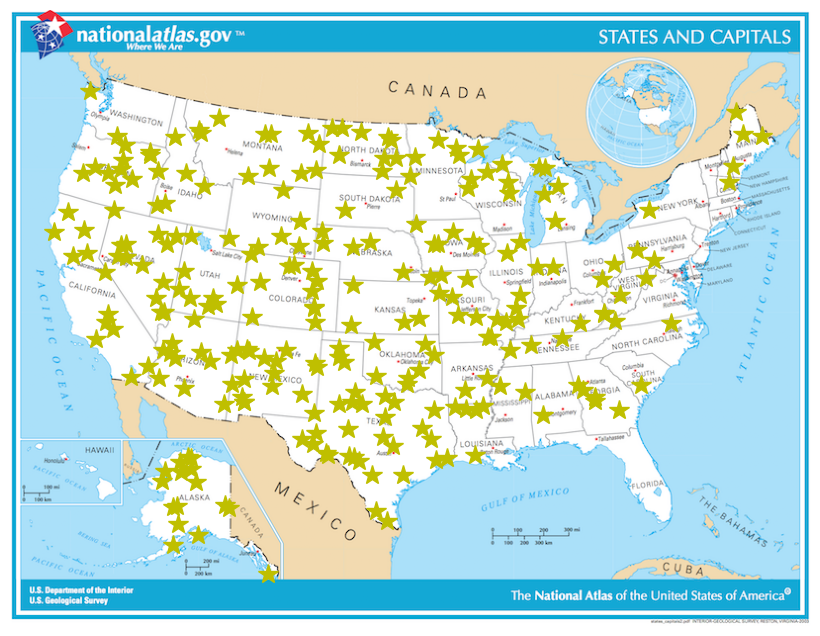

In [ ]:
import string
def create_cities(size, max_x=1000, max_y=1000, image=None, color=1, border=30):
    if (image is not None):
        max_x = image.shape[0] - 1 - border*2
        max_y = image.shape[1] - 1 - border*2
    cities = {}
    while len(cities) <= size:
        name = ''.join(random.choices(string.ascii_lowercase, k=10))
        x = round( border + random.random() * max_x,  1)
        y = round( border + random.random() * max_y,  1)
        if (image is not None) and not all( image[int(x)][int(y)] == color ): continue
        cities[(int(x),int(y))] = ( name, (y,x) )
    return list(cities.values())

np_hard = create_cities(256, image=united_states_map)
print(np_hard[:5])
show_cities(np_hard)

# Analiza manjih problema

Prvo pogledajmo neke od manjih problema:

- Za najmanje probleme (`N < 8`) većina vremena se troši na kretanje 1024 mrava tokom minimalno 4 puna kruga  
- Konvergencija traje eksponencijalno duže za svako udvostručenje veličine problema  
- Mravi i dalje mogu pronaći razumnu putanju za `N = 64`  



In [ ]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')
    show_path(result)
print()

Ograničimo vremensku složenost na N^2


In [ ]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')
    show_path(result)
print()

# Šta ako omogućimo varljivi režim sa `distance_power=10`

- Radi brže i efikasnije nego oslanjanje isključivo na feromonski trag  
- Čak i uz ograničenje vremenske složenosti na N² za broj mrava, vrijeme izvršavanja za N = 256 i dalje je 14 minuta  



In [ ]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, distance_power=10, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')
    show_path(result)
print()

# Dalje čitanje

Ant Colony Optimization algoritam se može proširiti korištenjem KMeans klasterovanja, što donosi poboljšanje performansi za veće mape (N = 64 do N = 512)
